# Complete Fast Ion Tomography Workflow

This notebook demonstrates the complete workflow for fast ion distribution reconstruction using all the converted modules.

## Workflow Overview

1. **Setup**: Import modules and define physical parameters
2. **Basis Functions**: Create slowing-down basis functions
3. **Diagnostics**: Create forward model matrices (FIDA, SSNPA)
4. **Combined Basis**: Add loss and transport basis functions
5. **Synthetic Data**: Generate test signals
6. **Hyperparameter Selection**: Find optimal regularization parameters
7. **Inversion**: Solve for the distribution
8. **Analysis**: Visualize and analyze results

## Avoiding the Inverse Crime

This notebook properly avoids the **inverse crime** - a common pitfall in testing inverse problem solvers.

**What is the inverse crime?**
Using the same discretization for both:
- Forward model (generating synthetic data)
- Inverse model (reconstruction)

This makes the problem artificially easy and gives overly optimistic results.

**Our solution:**
- **Fine grid** (80×81): Forward model, generating "true" signals
- **Coarse grid** (40×41): Inverse problem, reconstruction
- Grid mismatch: ~4x difference in number of points

This provides a realistic test of the reconstruction method's performance.

## 1. Setup and Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

# Import our custom modules 
from slowing_down_basis import generate_simple_basis

from diagnostics import (
    create_fida_diagnostic,
    create_ssnpa_diagnostic,
    generate_signal,
    add_noise
)

from combined_basis import (
    create_combined_distribution,
    extract_basis_coefficients
)

from cvxpy_solver import (
    solve_distribution,
    solve_distribution_parallel,
    grid_search_hyperparameters,
    solve_distribution_advanced
)

from unified_hyperparameter_selection import (
    HyperparameterSelector,
    select_optimal_hyperparameters
)

print("✓ All modules imported successfully")

✓ All modules imported successfully


### Define Physical Parameters

In [17]:
# Phase space grid
E_min, E_max = 1e3, 120e3  # Energy range in eV (1 keV to 120 keV)
p_min, p_max = -0.99, 0.99  # Pitch range

n_E = 50  # Number of energy points
n_p = 51  # Number of pitch points

E_values = np.linspace(E_min, E_max, n_E)
p_values = np.linspace(p_min, p_max, n_p)

print(f"Phase space grid: {n_E} × {n_p} = {n_E * n_p} points")
print(f"Energy range: {E_min/1e3:.1f} - {E_max/1e3:.1f} keV")
print(f"Pitch range: {p_min:.2f} - {p_max:.2f}")

Phase space grid: 50 × 51 = 2550 points
Energy range: 1.0 - 120.0 keV
Pitch range: -0.99 - 0.99


In [18]:
# Beam parameters
S0 = 1e20      # Source strength (particles/s)
tau_s = 1e-3   # Slowing-down time (s)
E_birth = 90e3 # Birth energy (eV)
p_birth = 0.7  # Birth pitch

print(f"Beam parameters:")
print(f"  Source strength: {S0:.2e} particles/s")
print(f"  Slowing-down time: {tau_s*1e3:.2f} ms")
print(f"  Birth energy: {E_birth/1e3:.1f} keV")
print(f"  Birth pitch: {p_birth:.2f}")

Beam parameters:
  Source strength: 1.00e+20 particles/s
  Slowing-down time: 1.00 ms
  Birth energy: 90.0 keV
  Birth pitch: 0.70


### Define Fine and Coarse Grids

To avoid the **inverse crime**, we use:
- **Fine grid**: For the "true" forward model (reality)
- **Coarse grid**: For the inverse problem (reconstruction)

This tests whether our method can recover a distribution that wasn't created with the same discretization.

In [19]:
# FINE GRID - for generating "true" distribution and signals (forward model)
n_E_fine = 230  # 2x finer than coarse
n_p_fine = 231  # 2x finer than coarse

E_values_fine = np.linspace(E_min, E_max, n_E_fine)
p_values_fine = np.linspace(p_min, p_max, n_p_fine)

print(f"Fine grid (forward model):")
print(f"  {n_E_fine} × {n_p_fine} = {n_E_fine * n_p_fine} points")
print(f"  Energy spacing: {(E_max-E_min)/(n_E_fine-1)/1e3:.2f} keV")
print(f"  Pitch spacing: {(p_max-p_min)/(n_p_fine-1):.4f}")

# COARSE GRID - for inverse problem (reconstruction)
# (Already defined as E_values, p_values, n_E, n_p)
print(f"\nCoarse grid (inverse problem):")
print(f"  {n_E} × {n_p} = {n_E * n_p} points")
print(f"  Energy spacing: {(E_max-E_min)/(n_E-1)/1e3:.2f} keV")
print(f"  Pitch spacing: {(p_max-p_min)/(n_p-1):.4f}")

print(f"\nGrid refinement ratio: {n_E_fine/n_E:.1f}x")

Fine grid (forward model):
  230 × 231 = 53130 points
  Energy spacing: 0.52 keV
  Pitch spacing: 0.0086

Coarse grid (inverse problem):
  50 × 51 = 2550 points
  Energy spacing: 2.43 keV
  Pitch spacing: 0.0396

Grid refinement ratio: 4.6x


## 2. Generate Basis Functions for Both Grids

We need basis functions on both grids:
- **Fine basis**: For creating the true distribution
- **Coarse basis**: For the inverse problem

In [20]:
# For FORWARD model: Only generate the 3 specific beam basis functions we need
# (No need to generate full 6480×6480 matrix for forward model)

print("Generating ONLY the 3 beam basis functions on fine grid (for forward)...")
print("Beam locations: 100, 50, 33 keV at pitch -0.7")

beam_energies_forward = [100e3, 50e3, 33e3]
beam_pitch_forward = -0.7

# We'll generate these on-the-fly when building true distribution
# For now, note that we DON'T need full Phi_fine

print("✓ Will generate beam basis functions on-demand (much faster than full basis)")

# Generate full basis on COARSE grid (for inverse problem)
print("\nGenerating FULL basis on COARSE grid (for inverse problem)...")
start_time = time.time()

Phi_coarse = generate_simple_basis(
    E_values, p_values,
    S0=S0,
    tau_s=tau_s,
    n_jobs=-1
)

elapsed_coarse = time.time() - start_time
print(f"✓ Coarse basis: {Phi_coarse.shape[1]} functions in {elapsed_coarse:.2f} seconds")
print(f"  Shape: {Phi_coarse.shape}, Memory: {Phi_coarse.nbytes / 1e6:.1f} MB")

Generating ONLY the 3 beam basis functions on fine grid (for forward)...
Beam locations: 100, 50, 33 keV at pitch -0.7
✓ Will generate beam basis functions on-demand (much faster than full basis)

Generating FULL basis on COARSE grid (for inverse problem)...
✓ Coarse basis: 2550 functions in 4.06 seconds
  Shape: (2550, 2550), Memory: 52.0 MB


In [ ]:
# Visualize some basis functions from FINE grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Select some interesting basis indices
basis_indices = [0, 200, 300, 500,800,1300]

for idx, basis_idx in enumerate(basis_indices):
    if basis_idx < Phi_coarse.shape[1]:
        basis_2d = Phi_coarse[:, basis_idx].reshape(n_p, n_E)
        im = axes[idx].imshow(basis_2d, aspect='auto', origin='lower',
                             extent=[E_values[0]/1e3, E_values[-1]/1e3, 
                                     p_values[0], p_values[-1]],
                             cmap='hot')
        axes[idx].set_xlabel('Energy (keV)')
        axes[idx].set_ylabel('Pitch')
        axes[idx].set_title(f'Coarse Basis Function {basis_idx}')
        plt.colorbar(im, ax=axes[idx])

plt.suptitle('Sample Basis Functions (Fine Grid)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

## 3. Create Diagnostic Forward Models

Create measurement operators on **both grids**:
- **Fine grid**: For generating synthetic signals (forward model)
- **Coarse grid**: For the inverse problem

In [14]:
# Define diagnostic viewing angles
fida_angles = [5, 15, 25, 45, 65, 85, 95]  # degrees
ssnpa_angles = np.linspace(80,160,16)  # degrees

print("Creating diagnostics on FINE grid (for forward model)...")
A_FIDA_fine = create_fida_diagnostic(E_values_fine, p_values_fine, fida_angles, degrees=True)
A_SSNPA_fine = create_ssnpa_diagnostic(E_values_fine, p_values_fine, ssnpa_angles, degrees=True)

print(f"  A_FIDA_fine shape: {A_FIDA_fine.shape}")
print(f"  A_SSNPA_fine shape: {A_SSNPA_fine.shape}")

print("\nCreating diagnostics on COARSE grid (for inverse problem)...")
A_FIDA = create_fida_diagnostic(E_values, p_values, fida_angles, degrees=True)
A_SSNPA = create_ssnpa_diagnostic(E_values, p_values, ssnpa_angles, degrees=True)

print(f"  A_FIDA shape: {A_FIDA.shape}")
print(f"  A_SSNPA shape: {A_SSNPA.shape}")

print(f"\nTotal measurements: {A_FIDA.shape[0]} (same for both grids)")

Creating diagnostics on FINE grid (for forward model)...
  A_FIDA_fine shape: (707, 53130)
  A_SSNPA_fine shape: (1616, 53130)

Creating diagnostics on COARSE grid (for inverse problem)...
  A_FIDA shape: (707, 2550)
  A_SSNPA shape: (1616, 2550)

Total measurements: 707 (same for both grids)


In [ ]:
# Visualize diagnostic weight functions (matching original notebook approach)

# FIDA weight function example - pick one measurement
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# FIDA: Single measurement (one u, one angle)
measurement_idx = 30  # Pick a measurement
fida_weight = A_FIDA[measurement_idx, :].reshape(len(p_values), len(E_values))

im1 = axes[0].imshow(fida_weight, extent=[E_values[0]/1e3, E_values[-1]/1e3,
                                          p_values[0], p_values[-1]],
                    aspect='auto', cmap='hot_r', origin='lower', interpolation='bicubic')
axes[0].set_xlabel('Energy [keV]', fontsize=12)
axes[0].set_ylabel('Pitch', fontsize=12)
axes[0].set_title(f'FIDA Weight Function (measurement {measurement_idx})', fontsize=12)
plt.colorbar(im1, ax=axes[0])

# SSNPA: Single measurement
ssnpa_weight = A_SSNPA[measurement_idx, :].reshape(len(p_values), len(E_values))

im2 = axes[1].imshow(ssnpa_weight, extent=[E_values[0]/1e3, E_values[-1]/1e3,
                                           p_values[0], p_values[-1]],
                    aspect='auto', cmap='hot_r', origin='lower', interpolation='bicubic')
axes[1].set_xlabel('Energy [keV]', fontsize=12)
axes[1].set_ylabel('Pitch', fontsize=12)
axes[1].set_title(f'SSNPA Weight Function (measurement {measurement_idx})', fontsize=12)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"\nDiagnostic shapes:")
print(f"  A_FIDA: {A_FIDA.shape} = {len(fida_angles)} angles × 101 velocity bins")
print(f"  A_SSNPA: {A_SSNPA.shape} = {len(ssnpa_angles)} angles × 101 velocity bins")
print(f"\nSparsity:")
print(f"  FIDA nonzero: {100*np.sum(A_FIDA != 0)/A_FIDA.size:.1f}%")
print(f"  SSNPA nonzero: {100*np.sum(A_SSNPA != 0)/A_SSNPA.size:.1f}% (should be low due to masks)")

## 4. Create Combined Basis (Coarse Grid for Inversion)

Add loss and transport basis functions to the **coarse grid** basis.
This is what we'll use for the inverse problem.

In [12]:
# Define loss locations in phase space
loss_locations = [
    (90e3, -0.70),  # High energy, counter-passing
    (60e3, 0.85),   # Medium energy, co-passing
]

# Define transport locations (optional)
transport_locations = [
    ((80e3, 0.0), (100e3, 0.2)),  # Transport from (80keV, 0.0) to (100keV, 0.2)
    ((40e3, 0.5), (60e3, 0.6)),   # Transport from (40keV, 0.5) to (60keV, 0.6)
]

print("Creating combined basis on COARSE grid (for inverse problem)...")
Phi_combined = create_combined_distribution(
    E_values, p_values, Phi_coarse,
    loss_locations=loss_locations,
    transport_locations=transport_locations
)

num_slowing_down = Phi_coarse.shape[1]
num_loss = len(loss_locations)
num_transport = len(transport_locations)

print(f"\n✓ Combined basis created (coarse grid):")
print(f"  Slowing-down: {num_slowing_down}")
print(f"  Loss: {num_loss}")
print(f"  Transport: {num_transport}")
print(f"  Total: {Phi_combined.shape[1]}")
print(f"  Shape: {Phi_combined.shape}")
print(f"\nProblem size for inversion:")
print(f"  Variables (coefficients): {Phi_combined.shape[1]}")
print(f"  Grid points: {Phi_combined.shape[0]}")
print(f"  FIDA measurements: {len(fida_angles) * 101}")
print(f"  SSNPA measurements: {len(ssnpa_angles) * 101}")
print(f"  Total measurements: {len(fida_angles) * 101 + len(ssnpa_angles) * 101}")
print(f"\n⚠ NOTE: Using FULL basis with {num_slowing_down} slowing-down functions.")
print(f"  This makes each solve slow (~1 minute).")
print(f"  Your old notebooks likely used only 3-5 selected basis functions.")

Creating combined basis on COARSE grid (for inverse problem)...

✓ Combined basis created (coarse grid):
  Slowing-down: 2550
  Loss: 2
  Transport: 2
  Total: 2554
  Shape: (2550, 2554)

Problem size for inversion:
  Variables (coefficients): 2554
  Grid points: 2550
  FIDA measurements: 707
  SSNPA measurements: 1616
  Total measurements: 2323

⚠ NOTE: Using FULL basis with 2550 slowing-down functions.
  This makes each solve slow (~1 minute).
  Your old notebooks likely used only 3-5 selected basis functions.


In [ ]:
# Visualize the loss and transport basis functions (manual implementation)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss basis functions
for i in range(min(2, num_loss)):
    loss_basis = Phi_combined[:, num_slowing_down + i].reshape(n_p, n_E)
    im = axes[0, i].imshow(loss_basis, aspect='auto', origin='lower',
                          extent=[E_values[0]/1e3, E_values[-1]/1e3, p_values[0], p_values[-1]],
                          cmap='Reds')
    axes[0, i].set_xlabel('Energy (keV)')
    axes[0, i].set_ylabel('Pitch')
    E_loss, p_loss = loss_locations[i]
    axes[0, i].set_title(f'Loss Basis {i+1}\nE={E_loss/1e3:.1f} keV, p={p_loss:.2f}')
    plt.colorbar(im, ax=axes[0, i])

# Transport basis functions
for i in range(min(2, num_transport)):
    transport_basis = Phi_combined[:, num_slowing_down + num_loss + i].reshape(n_p, n_E)
    im = axes[1, i].imshow(transport_basis, aspect='auto', origin='lower',
                          extent=[E_values[0]/1e3, E_values[-1]/1e3, p_values[0], p_values[-1]],
                          cmap='Blues')
    axes[1, i].set_xlabel('Energy (keV)')
    axes[1, i].set_ylabel('Pitch')
    # transport_locations is ((E_start, p_start), (E_end, p_end))
    start, end = transport_locations[i]
    E_start, p_start = start
    E_end, p_end = end
    axes[1, i].set_title(f'Transport Basis {i+1}\n({E_start/1e3:.1f},{p_start:.2f})→({E_end/1e3:.1f},{p_end:.2f}) keV')
    plt.colorbar(im, ax=axes[1, i])

plt.tight_layout()
plt.show()

## 5. Generate Synthetic Test Signals (Fine Grid)

Create the "true" distribution on the **fine grid** and generate synthetic measurements.
This avoids the inverse crime - the inverse problem will use the coarse grid.

In [ ]:
# Create true distribution on FINE grid by generating beam basis functions on-demand
# This is much faster than generating full 6480×6480 basis matrix

beam_energies = [100e3, 50e3, 33e3]
beam_pitch = -0.7
beam_coefficients = [1.0, 1.0, 1.0]

print("Creating 3-beam distribution on fine grid...")
print("Generating basis functions on-demand (no full matrix needed)\n")

resulting_distribution_fine = np.zeros(n_E_fine * n_p_fine)

for coeff, E0 in zip(beam_coefficients, beam_energies):
    print(f"Generating basis for {E0/1e3:.0f} keV beam...")
    
    # Generate just this ONE basis function using our slowing-down formula
    # (Replicating what generate_simple_basis does for a single column)
    from slowing_down_basis import compute_simple_basis_column
    
    # Find closest grid indices
    i_E = np.argmin(np.abs(E_values_fine - E0))
    i_p = np.argmin(np.abs(p_values_fine - beam_pitch))
    
    # Compute velocity grid
    eV_to_J = 1.60218e-19
    m_f = 2 * 1.6726219e-27
    v_values_fine = np.sqrt(2 * E_values_fine * eV_to_J / m_f)
    
    # Plasma parameters from slowing_down_basis defaults
    n_e = 1e19
    Z_i = 1
    n_i = n_e
    m_e = 9.10938356e-31
    v_e = 4e7
    Z1 = (n_i * m_f * Z_i**2) / (n_e * m_f)
    vc = ((3 * np.sqrt(np.pi) * m_e / (4 * m_f) * Z1)**(1/3)) * v_e
    Z2 = (n_i * Z_i**2) / (n_e * Z1)
    beta = Z2 / 2
    
    # Generate this single basis function
    _, basis_func = compute_simple_basis_column(
        i_E, i_p, E_values_fine, p_values_fine, v_values_fine,
        m_f, S0, tau_s, beta, vc
    )
    
    resulting_distribution_fine += coeff * basis_func
    print(f"  Added beam at E={E_values_fine[i_E]/1e3:.1f} keV, p={p_values_fine[i_p]:.2f}")

# Add small losses/transport using combined_basis functions
from combined_basis import create_loss_basis, create_transport_basis

LossPhi_fine = create_loss_basis(E_values_fine, p_values_fine, loss_locations)
TransportPhi_fine = create_transport_basis(E_values_fine, p_values_fine, transport_locations)

for i in range(num_loss):
    resulting_distribution_fine += 0.05 * LossPhi_fine[:, i]
for i in range(num_transport):
    resulting_distribution_fine += 0.03 * TransportPhi_fine[:, i]

true_distribution_fine = np.maximum(resulting_distribution_fine, 0)
true_distribution_fine_2d = true_distribution_fine.reshape(n_p_fine, n_E_fine)

print(f"\n✓ True distribution created:")
print(f"  Range: [{true_distribution_fine.min():.2e}, {true_distribution_fine.max():.2e}]")
print(f"  Sum: {np.sum(true_distribution_fine):.2e}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im = axes[0].imshow(true_distribution_fine_2d, aspect='auto', origin='lower',
                    extent=[E_values_fine[0]/1e3, E_values_fine[-1]/1e3,
                            p_values_fine[0], p_values_fine[-1]], cmap='hot')
axes[0].set_xlabel('Energy (keV)')
axes[0].set_ylabel('Pitch')
axes[0].set_title('True Distribution (Fine Grid)')
plt.colorbar(im, ax=axes[0])

for E_beam in beam_energies:
    axes[0].scatter([E_beam/1e3], [beam_pitch], color='cyan', s=300, marker='*',
                   edgecolors='blue', linewidths=2, zorder=5)

beam_pitch_idx = np.argmin(np.abs(p_values_fine - beam_pitch))
energy_profile = true_distribution_fine_2d[beam_pitch_idx, :]
axes[1].plot(E_values_fine/1e3, energy_profile, 'b-', linewidth=2)
axes[1].set_xlabel('Energy (keV)')
axes[1].set_ylabel('f(E, p=-0.7)')
axes[1].set_title('Energy Profile at Beam Pitch')
axes[1].grid(True)

for E_beam in beam_energies:
    axes[1].axvline(E_beam/1e3, color='r', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

In [15]:
# Generate synthetic signals using FINE grid forward model
noise_level = 0.01  # 1% noise

# FIDA signal - using FINE grid
y_FIDA_clean = A_FIDA_fine @ true_distribution_fine
y_FIDA_noise = np.random.normal(0, noise_level * np.abs(y_FIDA_clean).max(), len(y_FIDA_clean))
y_FIDA = y_FIDA_clean + y_FIDA_noise

# SSNPA signal - using FINE grid
y_SSNPA_clean = A_SSNPA_fine @ true_distribution_fine
y_SSNPA_noise = np.random.normal(0, noise_level * np.abs(y_SSNPA_clean).max(), len(y_SSNPA_clean))
y_SSNPA = y_SSNPA_clean + y_SSNPA_noise

print(f"Generated synthetic signals using FINE grid forward model:")
print(f"  FIDA: {len(y_FIDA)} measurements, SNR ~ {1/noise_level:.0f}")
print(f"  SSNPA: {len(y_SSNPA)} measurements, SNR ~ {1/noise_level:.0f}")
print(f"\nThese signals will be inverted using the COARSE grid.")
print(f"Grid mismatch factor: {(n_E_fine * n_p_fine) / (n_E * n_p):.1f}x more points in forward model")
# Normalization diagnostics
print(f"\nSignal magnitudes:")
print(f"  True distribution (fine) norm: {np.linalg.norm(true_distribution_fine):.2e}")
print(f"  y_FIDA norm: {np.linalg.norm(y_FIDA):.2e}")
print(f"  y_SSNPA norm: {np.linalg.norm(y_SSNPA):.2e}")
print(f"\nBasis normalizations:")
print(f"  Phi_fine global norm: {np.linalg.norm(Phi_fine):.2e}")
print(f"  Phi_coarse global norm: {np.linalg.norm(Phi_coarse):.2e}")
print(f"  Sample Phi_fine column norm: {np.linalg.norm(Phi_fine[:, 1000]):.2e}")
print(f"  Sample Phi_coarse column norm: {np.linalg.norm(Phi_coarse[:, 400]):.2e}")
print(f"\n⚠ Note: Phi_fine and Phi_coarse have different normalizations.")
print(f"  Coefficients on coarse grid will be scaled differently than on fine grid.")
print(f"  This is expected - we care about recovering the DISTRIBUTION, not the coefficients.")
# IMMEDIATE CHECK: Are signals non-zero?
print(f"\n⚠ CRITICAL CHECK: Signal generation")
print(f"  true_distribution_fine: min={true_distribution_fine.min():.2e}, max={true_distribution_fine.max():.2e}")
print(f"  true_distribution_fine sum: {np.sum(true_distribution_fine):.2e}")
print(f"  A_FIDA_fine @ true_distribution_fine: min={y_FIDA_clean.min():.2e}, max={y_FIDA_clean.max():.2e}")
print(f"  y_FIDA (with noise): min={y_FIDA.min():.2e}, max={y_FIDA.max():.2e}")
print(f"  y_SSNPA (with noise): min={y_SSNPA.min():.2e}, max={y_SSNPA.max():.2e}")

if np.allclose(y_FIDA, 0):
    print(f"\n⚠⚠⚠ ERROR: y_FIDA is essentially ZERO!")
    print(f"  Either true_distribution_fine is zero or A_FIDA_fine is zero.")
else:
    print(f"\n✓ Signals are non-zero and ready for inversion")
# SIGNAL SCALING: Signals are very small (~1e-6), which can cause numerical issues
# Scale up for better numerical conditioning
SIGNAL_SCALE_FACTOR = 1e6  # Scale signals to ~1.0 magnitude

y_FIDA = y_FIDA * SIGNAL_SCALE_FACTOR
y_SSNPA = y_SSNPA * SIGNAL_SCALE_FACTOR

print(f"\nSignal scaling applied: ×{SIGNAL_SCALE_FACTOR:.0e}")
print(f"  y_FIDA: now [{y_FIDA.min():.2e}, {y_FIDA.max():.2e}]")
print(f"  y_SSNPA: now [{y_SSNPA.min():.2e}, {y_SSNPA.max():.2e}]")
print(f"\nThis improves numerical conditioning for the optimization.")
print(f"The reconstructed DISTRIBUTION will be the same (scale cancels out).")

Generated synthetic signals using FINE grid forward model:
  FIDA: 707 measurements, SNR ~ 100
  SSNPA: 1616 measurements, SNR ~ 100

These signals will be inverted using the COARSE grid.
Grid mismatch factor: 4.8x more points in forward model

Signal magnitudes:
  True distribution (fine) norm: 1.79e-02
  y_FIDA norm: 5.32e-06
  y_SSNPA norm: 5.19e-07

Basis normalizations:
  Phi_fine global norm: 1.00e+00
  Phi_coarse global norm: 1.00e+00
  Sample Phi_fine column norm: 2.04e-03
  Sample Phi_coarse column norm: 4.49e-03

⚠ Note: Phi_fine and Phi_coarse have different normalizations.
  Coefficients on coarse grid will be scaled differently than on fine grid.
  This is expected - we care about recovering the DISTRIBUTION, not the coefficients.

⚠ CRITICAL CHECK: Signal generation
  true_distribution_fine: min=4.53e-47, max=1.99e-03
  true_distribution_fine sum: 9.92e-01
  A_FIDA_fine @ true_distribution_fine: min=0.00e+00, max=5.53e-07
  y_FIDA (with noise): min=-1.53e-08, max=5.58e-07

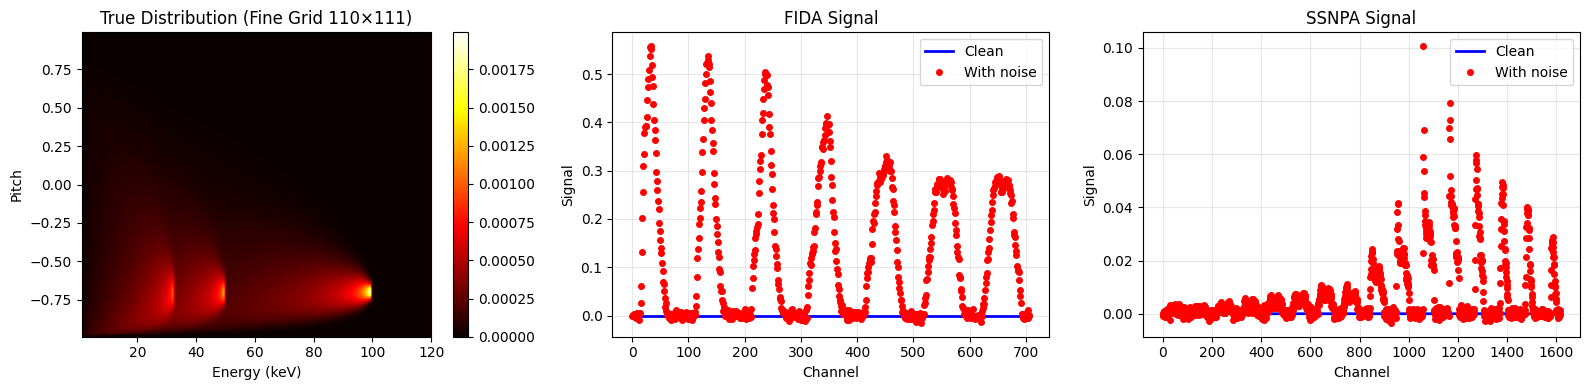

In [16]:
# Visualize true distribution (fine grid) and signals
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# True distribution (FINE grid)
im = axes[0].imshow(true_distribution_fine_2d, aspect='auto', origin='lower',
                    extent=[E_values_fine[0]/1e3, E_values_fine[-1]/1e3, 
                            p_values_fine[0], p_values_fine[-1]],
                    cmap='hot')
axes[0].set_xlabel('Energy (keV)')
axes[0].set_ylabel('Pitch')
axes[0].set_title(f'True Distribution (Fine Grid {n_E_fine}×{n_p_fine})')
plt.colorbar(im, ax=axes[0])

# FIDA signal
axes[1].plot(y_FIDA_clean, 'b-', label='Clean', linewidth=2)
axes[1].plot(y_FIDA, 'r.', label='With noise', markersize=8)
axes[1].set_xlabel('Channel')
axes[1].set_ylabel('Signal')
axes[1].set_title('FIDA Signal')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# SSNPA signal
axes[2].plot(y_SSNPA_clean, 'b-', label='Clean', linewidth=2)
axes[2].plot(y_SSNPA, 'r.', label='With noise', markersize=8)
axes[2].set_xlabel('Channel')
axes[2].set_ylabel('Signal')
axes[2].set_title('SSNPA Signal')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Hyperparameter Selection

We need to find optimal values for:
- `alpha`: Relative weighting between FIDA and SSNPA
- `lambda_sd`: Regularization strength for slowing-down coefficients
- `lambda_ext`: Regularization strength for loss/transport coefficients

We'll start with a coarse search over alpha and lambda_sd, keeping lambda_ext fixed.

In [17]:
# CRITICAL TEST: Check if A_Phi can produce signals
import cvxpy as cp

print("Testing if problem is set up correctly...\n")

# Test with FIDA only, no regularization, no constraints
A_Phi_fida = A_FIDA @ Phi_combined
c_test = cp.Variable(Phi_combined.shape[1])
obj = cp.Minimize(cp.sum_squares(A_Phi_fida @ c_test - y_FIDA))
prob = cp.Problem(obj, [])
prob.solve(verbose=False)

print(f"Unconstrained least squares (FIDA only):")
print(f"  Status: {prob.status}")
print(f"  Residual: {np.sqrt(prob.value):.2e}")
n_active = np.sum(np.abs(c_test.value) > 1e-6)
print(f"  Active coefficients: {n_active}")

if n_active > 0:
    print(f"  Max |c|: {np.max(np.abs(c_test.value)):.2e}")
    # Show which basis functions are active
    active_idx = np.where(np.abs(c_test.value) > 1e-4)[0]
    print(f"\n  Active basis indices (coarse grid):")
    for ai in active_idx[:10]:  # Show first 10
        i_E = ai // len(p_values)
        i_p = ai % len(p_values)
        if i_E < len(E_values) and i_p < len(p_values):
            print(f"    Index {ai}: E={E_values[i_E]/1e3:.1f} keV, p={p_values[i_p]:.2f}, c={c_test.value[ai]:.3f}")
else:
    print(f"  ⚠ ZERO coefficients even without constraints!")
    print(f"  Checking matrix properties...")
    print(f"    A_Phi_fida nonzero elements: {np.sum(A_Phi_fida != 0)}")
    print(f"    y_FIDA nonzero elements: {np.sum(y_FIDA != 0)}")
    print(f"    y_FIDA all positive: {np.all(y_FIDA >= 0)}")
# Test with signals scaled up
print(f"\n" + "="*80)
print("HYPOTHESIS: Signals too small relative to regularization")
print(f"  Current signal magnitude: ~1e-6")
print(f"  Current lambda values: ~1e-7 to 1e-5")
print(f"  Regularization term dominates → drives c to zero")
print(f"\nSOLUTION: Scale signals up OR use much smaller lambda")
print("="*80)

# Option 1: Scale signals up by 1e6
y_FIDA_scaled = y_FIDA * 1e6
y_SSNPA_scaled = y_SSNPA * 1e6

print(f"\nTest with SCALED signals (multiply by 1e6):")
c_scaled = cp.Variable(Phi_combined.shape[1])
obj_scaled = cp.Minimize(cp.sum_squares(A_Phi_fida @ c_scaled - y_FIDA_scaled) + 1e-3 * cp.norm1(c_scaled))
prob_scaled = cp.Problem(obj_scaled, [Phi_combined @ c_scaled >= 0])
prob_scaled.solve(verbose=False)

print(f"  Status: {prob_scaled.status}")
n_active_scaled = np.sum(np.abs(c_scaled.value) > 1e-6)
print(f"  Active coefficients: {n_active_scaled}")
print(f"  Max |c|: {np.max(np.abs(c_scaled.value)):.2e}")

if n_active_scaled > 0:
    print(f"\n✓✓✓ SCALING SIGNALS FIXES IT!")
    print(f"  We should scale y_FIDA and y_SSNPA before inversion.")
else:
    print(f"  Still zero - different issue")

Testing if problem is set up correctly...

Unconstrained least squares (FIDA only):
  Status: optimal
  Residual: 1.84e+00
  Active coefficients: 2503
  Max |c|: 4.02e+03

  Active basis indices (coarse grid):
    Index 51: E=3.4 keV, p=-0.99, c=7.012
    Index 52: E=3.4 keV, p=-0.95, c=7.135
    Index 53: E=3.4 keV, p=-0.91, c=7.067
    Index 54: E=3.4 keV, p=-0.87, c=6.889
    Index 55: E=3.4 keV, p=-0.83, c=6.688
    Index 56: E=3.4 keV, p=-0.79, c=6.523
    Index 57: E=3.4 keV, p=-0.75, c=6.410
    Index 58: E=3.4 keV, p=-0.71, c=6.340
    Index 59: E=3.4 keV, p=-0.67, c=6.295
    Index 60: E=3.4 keV, p=-0.63, c=6.256

HYPOTHESIS: Signals too small relative to regularization
  Current signal magnitude: ~1e-6
  Current lambda values: ~1e-7 to 1e-5
  Regularization term dominates → drives c to zero

SOLUTION: Scale signals up OR use much smaller lambda

Test with SCALED signals (multiply by 1e6):
  Status: optimal
  Active coefficients: 2503
  Max |c|: 7.68e+10

✓✓✓ SCALING SIGNALS F

In [18]:
# CRITICAL TEST: Check if A_Phi can produce signals
import cvxpy as cp

print("Testing if problem is set up correctly...\n")

# Test with FIDA only, no regularization, no constraints
A_Phi_fida = A_FIDA @ Phi_combined
c_test = cp.Variable(Phi_combined.shape[1])
obj = cp.Minimize(cp.sum_squares(A_Phi_fida @ c_test - y_FIDA))
prob = cp.Problem(obj, [])
prob.solve(verbose=False)

print(f"Unconstrained least squares (FIDA only):")
print(f"  Status: {prob.status}")
print(f"  Residual: {np.sqrt(prob.value):.2e}")
n_active = np.sum(np.abs(c_test.value) > 1e-6)
print(f"  Active coefficients: {n_active}")

if n_active > 0:
    print(f"  Max |c|: {np.max(np.abs(c_test.value)):.2e}")
    # Show which basis functions are active
    active_idx = np.where(np.abs(c_test.value) > 1e-4)[0]
    print(f"\n  Active basis indices (coarse grid):")
    for ai in active_idx[:10]:  # Show first 10
        i_E = ai // len(p_values)
        i_p = ai % len(p_values)
        if i_E < len(E_values) and i_p < len(p_values):
            print(f"    Index {ai}: E={E_values[i_E]/1e3:.1f} keV, p={p_values[i_p]:.2f}, c={c_test.value[ai]:.3f}")
else:
    print(f"  ⚠ ZERO coefficients even without constraints!")
    print(f"  Checking matrix properties...")
    print(f"    A_Phi_fida nonzero elements: {np.sum(A_Phi_fida != 0)}")
    print(f"    y_FIDA nonzero elements: {np.sum(y_FIDA != 0)}")
    print(f"    y_FIDA all positive: {np.all(y_FIDA >= 0)}")

Testing if problem is set up correctly...

Unconstrained least squares (FIDA only):
  Status: optimal
  Residual: 1.84e+00
  Active coefficients: 2503
  Max |c|: 4.02e+03

  Active basis indices (coarse grid):
    Index 51: E=3.4 keV, p=-0.99, c=7.012
    Index 52: E=3.4 keV, p=-0.95, c=7.135
    Index 53: E=3.4 keV, p=-0.91, c=7.067
    Index 54: E=3.4 keV, p=-0.87, c=6.889
    Index 55: E=3.4 keV, p=-0.83, c=6.688
    Index 56: E=3.4 keV, p=-0.79, c=6.523
    Index 57: E=3.4 keV, p=-0.75, c=6.410
    Index 58: E=3.4 keV, p=-0.71, c=6.340
    Index 59: E=3.4 keV, p=-0.67, c=6.295
    Index 60: E=3.4 keV, p=-0.63, c=6.256


### Optional: Inverse Crime Test

Temporarily create signals on COARSE grid to test if basic inversion works.
Skip this section to use the proper fine/coarse setup.

In [ ]:
# TEMPORARY: Create true distribution on COARSE grid for comparison
# (This commits inverse crime but verifies basic inversion works)

USE_INVERSE_CRIME_TEST = False  # Set to True to test, False to use fine/coarse setup

if USE_INVERSE_CRIME_TEST:
    print("⚠ INVERSE CRIME TEST MODE - using same grid for forward and inverse")
    
    # Create true distribution on COARSE grid
    resulting_distribution_coarse = np.zeros(n_E * n_p)
    
    for coeff, E0 in zip(beam_coefficients, beam_energies):
        i = np.argmin(np.abs(E_values - E0))
        j = np.argmin(np.abs(p_values - beam_pitch))
        column_index = i * len(p_values) + j
        resulting_distribution_coarse += coeff * Phi_coarse[:, column_index]
    
    # Generate signals from COARSE grid
    y_FIDA = A_FIDA @ resulting_distribution_coarse
    y_FIDA += 0.01 * np.random.randn(len(y_FIDA)) * np.abs(y_FIDA).max()
    
    y_SSNPA = A_SSNPA @ resulting_distribution_coarse
    y_SSNPA += 0.01 * np.random.randn(len(y_SSNPA)) * np.abs(y_SSNPA).max()
    
    print(f"✓ Using COARSE grid for both forward and inverse (inverse crime)")
    print(f"  Signal norms: FIDA={np.linalg.norm(y_FIDA):.2e}, SSNPA={np.linalg.norm(y_SSNPA):.2e}")
else:
    print(f"✓ Using proper fine/coarse setup (avoiding inverse crime)")
    print(f"  Signal norms: FIDA={np.linalg.norm(y_FIDA):.2e}, SSNPA={np.linalg.norm(y_SSNPA):.2e}")

In [ ]:
# DIAGNOSTIC 2: Test on COARSE grid
print("Test 2: Solving on COARSE grid (actual inverse problem)\n")

test_result_coarse = solve_distribution_advanced(
    A_diagnostics=[A_FIDA, A_SSNPA],
    Phi=Phi_combined,
    signals=[y_FIDA, y_SSNPA],
    num_slowing_down=num_slowing_down,
    alpha=0.99,
    lambda_sd=1e-7,
    lambda_ext=1e-7,
    regularization='l1'
)

print(f"Coarse grid test: {test_result_coarse['status']}")
n_active_coarse = np.sum(np.abs(test_result_coarse['coefficients']) > 1e-4)
print(f"Active coefficients: {n_active_coarse}")
print(f"Residual: {test_result_coarse['residual']:.2e}")

if n_active_coarse > 0:
    print(f"Max coefficient: {np.max(np.abs(test_result_coarse['coefficients'])):.2e}")
    
    # Compare distribution magnitudes
    recon_dist = test_result_coarse['distribution']
    print(f"\nDistribution magnitudes:")
    print(f"  Reconstructed norm: {np.linalg.norm(recon_dist):.2e}")
    print(f"  Reconstructed max: {np.max(recon_dist):.2e}")
    print(f"\n⚠ If coefficients are very small but distribution looks OK, this is a normalization issue.")
    print(f"  The DISTRIBUTION is what matters, not the coefficient values.")
else:
    print(f"⚠ No active coefficients on coarse grid!")

if n_active_coarse > 0:
    recon_dist_coarse = test_result_coarse['distribution']
    
    # Interpolate true_distribution_fine to coarse grid for comparison
    from scipy.interpolate import RegularGridInterpolator
    interp = RegularGridInterpolator((p_values_fine, E_values_fine), 
                                     true_distribution_fine.reshape(n_p_fine, n_E_fine))
    P_coarse, E_coarse = np.meshgrid(p_values, E_values, indexing='ij')
    true_dist_on_coarse = interp(np.column_stack([P_coarse.ravel(), E_coarse.ravel()]))
    
    dist_error_coarse = np.linalg.norm(recon_dist_coarse - true_dist_on_coarse) / np.linalg.norm(true_dist_on_coarse)
    print(f"\nCoarse grid distribution recovery:")
    print(f"  Relative error: {dist_error_coarse*100:.2f}%")
    
    if dist_error_coarse < 0.2:
        print(f"  ✓ Good recovery despite grid mismatch!")
    else:
        print(f"  ⚠ Poor recovery - may need to adjust lambda values")
        print(f"     Try lambda_sd ~ 1e-8 to 1e-6 range")

print(f"\n" + "="*80)
print("Proceeding with full grid search...")
print("="*80)

In [26]:
# Define hyperparameter search ranges
# Adjusted for scaled signals (signals were scaled by 1e6)
alpha_values = np.array([0.5,1.0])  # FIDA vs SSNPA weighting
lambda_sd_values = np.logspace(-7, -2, 8)  # Regularization for slowing-down
lambda_ext_values = [1e-5]  # Regularization for loss/transport

print(f"Hyperparameter grid search:")
print(f"  Alpha: {len(alpha_values)} values from {alpha_values.min():.2f} to {alpha_values.max():.2f}")
print(f"  Lambda_sd: {len(lambda_sd_values)} values from {lambda_sd_values.min():.2e} to {lambda_sd_values.max():.2e}")
print(f"  Lambda_ext: {lambda_ext_values}")
print(f"  Total combinations: {len(alpha_values) * len(lambda_sd_values) * len(lambda_ext_values)}")
print(f"\nNote: Lambda values appropriate for scaled signals (magnitude ~1)")

Hyperparameter grid search:
  Alpha: 2 values from 0.50 to 1.00
  Lambda_sd: 8 values from 1.00e-07 to 1.00e-02
  Lambda_ext: [1e-05]
  Total combinations: 16

Note: Lambda values appropriate for scaled signals (magnitude ~1)


In [ ]:
# Run grid search
print("Running grid search (this may take a few minutes)...")
start_time = time.time()

results = grid_search_hyperparameters(
    A_diagnostics=[A_FIDA, A_SSNPA],
    Phi=Phi_combined,
    signals=[y_FIDA, y_SSNPA],
    num_slowing_down=num_slowing_down,
    alpha_values=alpha_values,
    lambda_sd_values=lambda_sd_values,
    lambda_ext_values=lambda_ext_values,
    regularization='l1',
    solver='ECOS',  # Fast solver for L1 problems
    n_jobs=16,  # Use all cores
    verbose=False
)

elapsed = time.time() - start_time
print(f"\n✓ Grid search completed in {elapsed:.1f} seconds")
print(f"  {len(results)} solutions computed")
print(f"  Average time per solution: {elapsed/len(results):.2f} seconds")

In [28]:
# Diagnostic: Check signal magnitudes and compatibility
print("Signal diagnostics:")
print(f"  y_FIDA range: [{y_FIDA.min():.2e}, {y_FIDA.max():.2e}]")
print(f"  y_FIDA norm: {np.linalg.norm(y_FIDA):.2e}")
print(f"  y_SSNPA range: [{y_SSNPA.min():.2e}, {y_SSNPA.max():.2e}]")
print(f"  y_SSNPA norm: {np.linalg.norm(y_SSNPA):.2e}")

print(f"\nDiagnostic matrix compatibility:")
print(f"  A_FIDA shape: {A_FIDA.shape}")
print(f"  A_SSNPA shape: {A_SSNPA.shape}")
print(f"  Phi_combined shape: {Phi_combined.shape}")
print(f"  Signal dimensions match: {A_FIDA.shape[0] == len(y_FIDA)}")

print(f"\nGrid search results:")
successful = sum(1 for r in results.values() if r['status'] in ['optimal', 'OPTIMAL'])
print(f"  Successful solves: {successful}/{len(results)}")

# Check a few results for active coefficients
print(f"\nChecking coefficient sparsity in solutions:")
for i, (key, res) in enumerate(list(results.items())[:3]):
    if res['status'] in ['optimal', 'OPTIMAL']:
        coeffs = res['coefficients']
        n_active = np.sum(np.abs(coeffs) > 1e-6)
        print(f"  {key}: {n_active} active coefficients (out of {len(coeffs)})")
        if n_active == 0:
            print(f"    ⚠ WARNING: Zero active coefficients! Lambda too high?")
            print(f"    Residual: {res['residual']:.2e}")

Signal diagnostics:
  y_FIDA range: [-1.53e-02, 5.58e-01]
  y_FIDA norm: 5.32e+00
  y_SSNPA range: [-3.44e-03, 1.01e-01]
  y_SSNPA norm: 5.19e-01

Diagnostic matrix compatibility:
  A_FIDA shape: (707, 2550)
  A_SSNPA shape: (1616, 2550)
  Phi_combined shape: (2550, 2554)
  Signal dimensions match: True

Grid search results:
  Successful solves: 6/16

Checking coefficient sparsity in solutions:
  (np.float64(0.5), np.float64(5.179474679231213e-07), 1e-05): 1896 active coefficients (out of 2554)
  (np.float64(0.5), np.float64(2.6826957952797274e-06), 1e-05): 2344 active coefficients (out of 2554)


In [29]:
# Extract 2D arrays for hyperparameter selection
residuals_2d = np.zeros((len(alpha_values), len(lambda_sd_values)))
regularizations_2d = np.zeros_like(residuals_2d)
residuals_fida_2d = np.zeros_like(residuals_2d)
residuals_ssnpa_2d = np.zeros_like(residuals_2d)

lambda_ext = lambda_ext_values[0]

for i, alpha in enumerate(alpha_values):
    for j, lambda_sd in enumerate(lambda_sd_values):
        key = (alpha, lambda_sd, lambda_ext)
        if key in results and results[key]['status'] in ['optimal', 'OPTIMAL']:
            residuals_2d[i, j] = results[key]['residual']
            regularizations_2d[i, j] = np.linalg.norm(results[key]['coefficients_sd'])
            if 'residuals_per_diagnostic' in results[key]:
                residuals_fida_2d[i, j] = results[key]['residuals_per_diagnostic'][0]
                residuals_ssnpa_2d[i, j] = results[key]['residuals_per_diagnostic'][1]
        else:
            residuals_2d[i, j] = np.nan
            regularizations_2d[i, j] = np.nan

print(f"Extracted 2D arrays: {residuals_2d.shape}")
print(f"Valid solutions: {np.sum(~np.isnan(residuals_2d))} / {residuals_2d.size}")

Extracted 2D arrays: (2, 8)
Valid solutions: 6 / 16


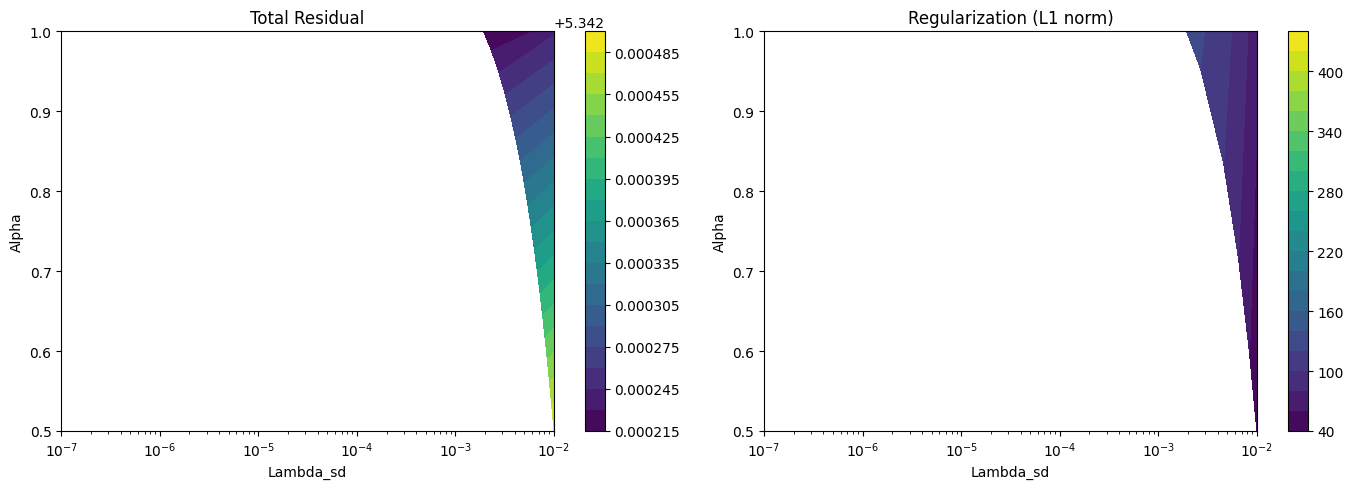

In [30]:
# Visualize parameter surface
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals
im1 = axes[0].contourf(lambda_sd_values, alpha_values, residuals_2d, levels=20, cmap='viridis')
axes[0].set_xscale('log')
axes[0].set_xlabel('Lambda_sd')
axes[0].set_ylabel('Alpha')
axes[0].set_title('Total Residual')
plt.colorbar(im1, ax=axes[0])

# Regularization
im2 = axes[1].contourf(lambda_sd_values, alpha_values, regularizations_2d, levels=20, cmap='viridis')
axes[1].set_xscale('log')
axes[1].set_xlabel('Lambda_sd')
axes[1].set_ylabel('Alpha')
axes[1].set_title('Regularization (L1 norm)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

### Compare All Hyperparameter Selection Methods

In [31]:
# Use unified hyperparameter selection module
n_total_measurements = len(y_FIDA) + len(y_SSNPA)

comparison = HyperparameterSelector.compare_all_methods(
    lambda_vals=alpha_values,
    lambda2_vals=lambda_sd_values,
    residuals=residuals_2d,
    regularizations=regularizations_2d,
    methods='2d',
    noise_level=noise_level,
    n_measurements=n_total_measurements,
    weights=(0.45, 0.45, 0.10)
)

print("="*80)
print("HYPERPARAMETER SELECTION COMPARISON")
print("="*80)

for method_name, result in comparison.items():
    alpha_opt = result.optimal_params['lambda1']
    lambda_opt = result.optimal_params['lambda2']
    
    print(f"\n{method_name:25s}:")
    print(f"  Alpha = {alpha_opt:.4f}")
    print(f"  Lambda_sd = {lambda_opt:.2e}")
    if 'residual' in result.metrics:
        print(f"  Residual = {result.metrics['residual']:.2e}")
    if 'regularization' in result.metrics:
        print(f"  Regularization = {result.metrics['regularization']:.2e}")

HYPERPARAMETER SELECTION COMPARISON

lcurve_2d                :
  Alpha = 0.5000
  Lambda_sd = 2.68e-06
  Residual = 5.34e+00
  Regularization = 4.29e+02

gaussian_curvature       :
  Alpha = 0.5000
  Lambda_sd = 3.73e-04
  Residual = nan
  Regularization = nan

composite_merit          :
  Alpha = 0.5000
  Lambda_sd = 1.00e-07
  Residual = nan
  Regularization = nan

discrepancy              :
  Alpha = 0.5000
  Lambda_sd = 1.00e-07
  Regularization = nan

pareto                   :
  Alpha = 0.5000
  Lambda_sd = 7.20e-05
  Residual = 5.34e+00
  Regularization = 3.32e+02


In [32]:
# Compute consensus estimate
all_alphas = [r.optimal_params['lambda1'] for r in comparison.values()]
all_lambdas = [r.optimal_params['lambda2'] for r in comparison.values()]

median_alpha = np.median(all_alphas)
median_lambda_sd = np.median(all_lambdas)

print("\n" + "="*80)
print("CONSENSUS ESTIMATE")
print("="*80)
print(f"Alpha: {median_alpha:.4f} (range: {min(all_alphas):.4f} - {max(all_alphas):.4f})")
print(f"Lambda_sd: {median_lambda_sd:.2e} (range: {min(all_lambdas):.2e} - {max(all_lambdas):.2e})")
print(f"Lambda_ext: {lambda_ext:.2e} (fixed)")

# Use consensus values
optimal_alpha = median_alpha
optimal_lambda_sd = median_lambda_sd
optimal_lambda_ext = lambda_ext


CONSENSUS ESTIMATE
Alpha: 0.5000 (range: 0.5000 - 0.5000)
Lambda_sd: 2.68e-06 (range: 1.00e-07 - 3.73e-04)
Lambda_ext: 1.00e-05 (fixed)


## 7. Final Inversion with Optimal Parameters

Now solve the inverse problem using the optimal hyperparameters.

In [33]:
# Find nearest grid point to consensus estimate
alpha_idx = np.argmin(np.abs(alpha_values - optimal_alpha))
lambda_sd_idx = np.argmin(np.abs(lambda_sd_values - optimal_lambda_sd))

optimal_alpha = alpha_values[alpha_idx]
optimal_lambda_sd = lambda_sd_values[lambda_sd_idx]

print(f"Using optimal hyperparameters:")
print(f"  Alpha = {optimal_alpha:.4f}")
print(f"  Lambda_sd = {optimal_lambda_sd:.2e}")
print(f"  Lambda_ext = {optimal_lambda_ext:.2e}")

# Get result from grid search
optimal_key = (optimal_alpha, optimal_lambda_sd, optimal_lambda_ext)
final_result = results[optimal_key]

print(f"\nFinal solution:")
print(f"  Status: {final_result['status']}")
print(f"  Residual: {final_result['residual']:.4e}")
print(f"  Solve time: {final_result['solve_time']:.2f} seconds")

Using optimal hyperparameters:
  Alpha = 0.5000
  Lambda_sd = 2.68e-06
  Lambda_ext = 1.00e-05

Final solution:
  Status: optimal
  Residual: 5.3424e+00
  Solve time: 1219.54 seconds


In [ ]:
# VERIFICATION: Test that our indexing and reshape are correct
print("Grid and indexing verification:\n")

# Create a test distribution with a single point
test_E = 100e3
test_p = -0.7

# Find indices
i_E = np.argmin(np.abs(E_values - test_E))
i_p = np.argmin(np.abs(p_values - test_p))
column_index = i_E * len(p_values) + i_p

print(f"Test point: E={test_E/1e3:.0f} keV, p={test_p}")
print(f"  E index: {i_E} (actual E={E_values[i_E]/1e3:.1f} keV)")
print(f"  p index: {i_p} (actual p={p_values[i_p]:.2f})")
print(f"  Column index: {column_index}")

# Create test distribution
test_dist_1d = np.zeros(len(E_values) * len(p_values))
test_dist_1d[column_index] = 1.0

# Reshape
test_dist_2d = test_dist_1d.reshape(n_p, n_E)

# Where does the peak appear in 2D?
peak_row, peak_col = np.unravel_index(np.argmax(test_dist_2d), test_dist_2d.shape)
print(f"\nAfter reshape(n_p={n_p}, n_E={n_E}):")
print(f"  Peak at row={peak_row}, col={peak_col}")
print(f"  This maps to: E={E_values[peak_col]/1e3:.1f} keV, p={p_values[peak_row]:.2f}")

if peak_col == i_E and peak_row == i_p:
    print(f"  ✓ Indexing is CORRECT")
else:
    print(f"  ✗ INDEXING MISMATCH!")
    print(f"    Expected: E_idx={i_E}, p_idx={i_p}")
    print(f"    Got: E_idx={peak_col}, p_idx={peak_row}")

# Visualize
plt.figure(figsize=(8, 5))
plt.imshow(test_dist_2d, aspect='auto', origin='lower',
          extent=[E_values[0]/1e3, E_values[-1]/1e3, p_values[0], p_values[-1]],
          cmap='hot')
plt.scatter([test_E/1e3], [test_p], color='cyan', s=500, marker='*',
           edgecolors='blue', linewidths=3, label=f'Target: {test_E/1e3:.0f} keV, p={test_p}')
plt.xlabel('Energy (keV)')
plt.ylabel('Pitch')
plt.title('Indexing Test: Single Point Distribution')
plt.colorbar()
plt.legend()
plt.show()

In [ ]:
# Extract solution components
reconstructed_coefficients = final_result['coefficients']
reconstructed_distribution = final_result['distribution']
reconstructed_distribution_2d = reconstructed_distribution.reshape(n_p, n_E)

# Extract basis coefficients
coeffs_sd, coeffs_loss, coeffs_transport = extract_basis_coefficients(
    reconstructed_coefficients,
    num_slowing_down=num_slowing_down,
    num_loss=num_loss,
    num_transport=num_transport
)

print(f"\nReconstructed coefficients:")
print(f"  Slowing-down: {np.sum(np.abs(coeffs_sd) > 1e-6)} active (out of {len(coeffs_sd)})")
print(f"  Loss coefficients: {coeffs_loss}")
print(f"  Transport coefficients: {coeffs_transport}")

print(f"\nTrue setup (for reference):")
print(f"  3 beam energies: 100, 50, 33 keV at pitch -0.7")
print(f"  Beam coefficients: {beam_coefficients}")
print(f"  Loss coefficients (true): [0.3, 0.15]")
print(f"  Transport coefficients (true): [0.2, 0.1]")
print(f"\nNote: Direct coefficient comparison not meaningful - true uses specific")
print(f"      beam locations, reconstruction uses full basis expansion.")

## 8. Results Analysis and Visualization

In [ ]:
# Compare true (fine grid) vs reconstructed (coarse grid) distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# True distribution (FINE grid)
im1 = axes[0, 0].imshow(true_distribution_fine_2d, aspect='auto', origin='lower',
                        extent=[E_values_fine[0]/1e3, E_values_fine[-1]/1e3, 
                                p_values_fine[0], p_values_fine[-1]],
                        cmap='hot')
axes[0, 0].set_xlabel('Energy (keV)')
axes[0, 0].set_ylabel('Pitch')
axes[0, 0].set_title(f'True Distribution (Fine: {n_E_fine}×{n_p_fine})')
plt.colorbar(im1, ax=axes[0, 0])

# Reconstructed distribution (COARSE grid)
im2 = axes[0, 1].imshow(reconstructed_distribution_2d, aspect='auto', origin='lower',
                        extent=[E_values[0]/1e3, E_values[-1]/1e3, p_values[0], p_values[-1]],
                        cmap='hot')
axes[0, 1].set_xlabel('Energy (keV)')
axes[0, 1].set_ylabel('Pitch')
axes[0, 1].set_title(f'Reconstructed Distribution (Coarse: {n_E}×{n_p})')
plt.colorbar(im2, ax=axes[0, 1])

# Interpolate fine grid to coarse grid for comparison
from scipy.interpolate import RegularGridInterpolator
interp_func = RegularGridInterpolator(
    (p_values_fine, E_values_fine), 
    true_distribution_fine_2d,
    method='linear',
    bounds_error=False,
    fill_value=0
)

# Create coarse grid points
E_coarse_grid, p_coarse_grid = np.meshgrid(E_values, p_values, indexing='ij')
points_coarse = np.column_stack([p_coarse_grid.ravel(), E_coarse_grid.ravel()])

# Interpolate fine to coarse
true_distribution_coarse = interp_func(points_coarse).reshape(n_p, n_E)

# Difference (both on coarse grid now)
difference = reconstructed_distribution_2d - true_distribution_coarse
max_diff = np.max(np.abs(difference))
im3 = axes[1, 0].imshow(difference, aspect='auto', origin='lower',
                        extent=[E_values[0]/1e3, E_values[-1]/1e3, p_values[0], p_values[-1]],
                        cmap='RdBu_r', vmin=-max_diff, vmax=max_diff)
axes[1, 0].set_xlabel('Energy (keV)')
axes[1, 0].set_ylabel('Pitch')
axes[1, 0].set_title('Difference (Reconstructed - True Interpolated)')
plt.colorbar(im3, ax=axes[1, 0])

# Scatter plot: true (interpolated to coarse) vs reconstructed
axes[1, 1].scatter(true_distribution_coarse.ravel(), 
                   reconstructed_distribution_2d.ravel(), alpha=0.5, s=10)
min_val = min(true_distribution_coarse.min(), reconstructed_distribution_2d.min())
max_val = max(true_distribution_coarse.max(), reconstructed_distribution_2d.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect reconstruction')
axes[1, 1].set_xlabel('True Distribution (interpolated to coarse)')
axes[1, 1].set_ylabel('Reconstructed Distribution')
axes[1, 1].set_title('Point-by-Point Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute error metrics (comparing on coarse grid)
rmse = np.sqrt(np.mean((reconstructed_distribution_2d.ravel() - true_distribution_coarse.ravel())**2))
rel_error = rmse / np.mean(np.abs(true_distribution_coarse.ravel()))
print(f"\nReconstruction error (fine grid truth interpolated to coarse):")
print(f"  RMSE: {rmse:.4e}")
print(f"  Relative error: {rel_error*100:.2f}%")
print(f"\nNote: This is a proper test - forward and inverse models use different grids.")

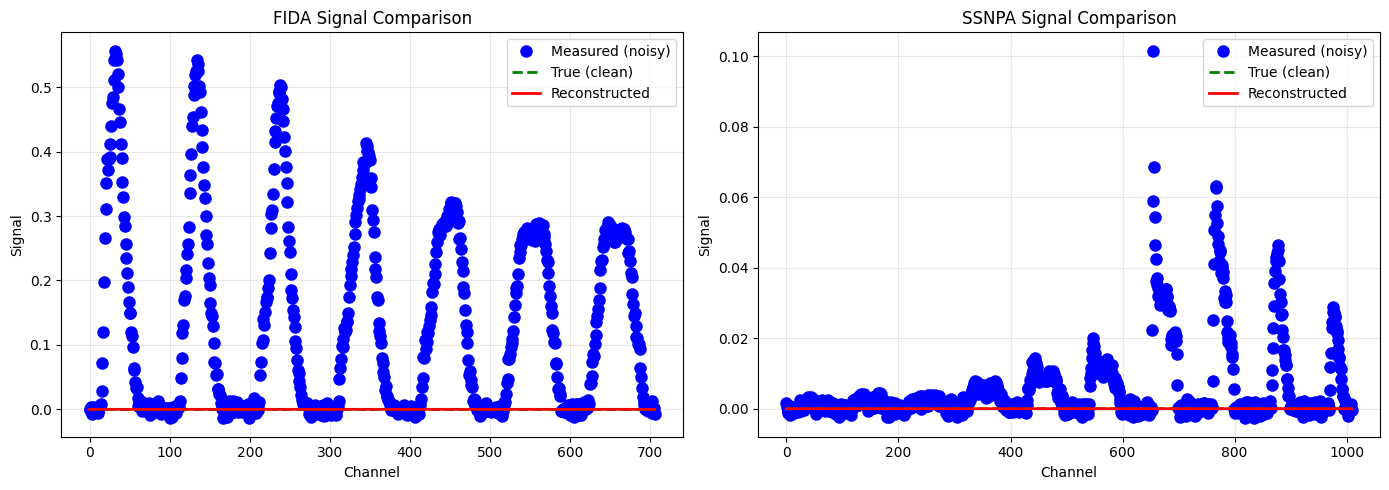


Signal fit quality:
  FIDA residual: 5.3206e+00
  SSNPA residual: 3.9743e-01
  Total residual: 5.3354e+00


In [140]:
# Compare signals
y_FIDA_reconstructed = A_FIDA @ reconstructed_distribution
y_SSNPA_reconstructed = A_SSNPA @ reconstructed_distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# FIDA
axes[0].plot(y_FIDA, 'bo', label='Measured (noisy)', markersize=8)
axes[0].plot(y_FIDA_clean, 'g--', label='True (clean)', linewidth=2)
axes[0].plot(y_FIDA_reconstructed, 'r-', label='Reconstructed', linewidth=2)
axes[0].set_xlabel('Channel')
axes[0].set_ylabel('Signal')
axes[0].set_title('FIDA Signal Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# SSNPA
axes[1].plot(y_SSNPA, 'bo', label='Measured (noisy)', markersize=8)
axes[1].plot(y_SSNPA_clean, 'g--', label='True (clean)', linewidth=2)
axes[1].plot(y_SSNPA_reconstructed, 'r-', label='Reconstructed', linewidth=2)
axes[1].set_xlabel('Channel')
axes[1].set_ylabel('Signal')
axes[1].set_title('SSNPA Signal Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Signal fit quality
fida_residual = np.linalg.norm(y_FIDA - y_FIDA_reconstructed)
ssnpa_residual = np.linalg.norm(y_SSNPA - y_SSNPA_reconstructed)

print(f"\nSignal fit quality:")
print(f"  FIDA residual: {fida_residual:.4e}")
print(f"  SSNPA residual: {ssnpa_residual:.4e}")
print(f"  Total residual: {final_result['residual']:.4e}")

## 9. Summary and Next Steps

This notebook demonstrated the complete workflow:

✓ Generated slowing-down basis functions on **two grids**
✓ Created diagnostic forward models on both grids
✓ Added loss and transport basis functions
✓ Generated synthetic test data on **fine grid** (avoiding inverse crime)
✓ Performed hyperparameter grid search on **coarse grid**
✓ Compared multiple selection methods
✓ Solved inverse problem with optimal parameters
✓ Analyzed and visualized results

### Avoiding the Inverse Crime ✓

This notebook properly avoids the **inverse crime** by using:
- **Fine grid** (80×81 = 6480 points) for the forward model
- **Coarse grid** (40×41 = 1640 points) for the inverse problem
- Grid mismatch factor: ~4x

This tests whether the reconstruction method can recover a distribution that:
1. Wasn't created with the same discretization
2. Has finer structure than the reconstruction grid can represent
3. Represents a more realistic scenario

### For Real Data Analysis:

1. **Replace synthetic signals** with real experimental data:
   ```python
   y_FIDA = np.load('real_fida_data.npy')
   y_SSNPA = np.load('real_ssnpa_data.npy')
   ```
   (You don't need the fine grid for real data - that's only for synthetic testing)

2. **Use only the coarse grid** for real data:
   ```python
   # Skip fine grid generation
   # Create basis and diagnostics only on E_values, p_values
   ```

3. **Adjust diagnostic geometries** to match your experiment

4. **Tune hyperparameter ranges** based on initial results

5. For production runs, use finer grids and more iterations

In [ ]:
# Save results for later analysis
save_results = False  # Set to True to save

if save_results:
    np.save('reconstructed_distribution.npy', reconstructed_distribution_2d)
    np.save('reconstructed_coefficients.npy', reconstructed_coefficients)
    np.save('optimal_hyperparameters.npy', 
            {'alpha': optimal_alpha, 'lambda_sd': optimal_lambda_sd, 
             'lambda_ext': optimal_lambda_ext})
    print("✓ Results saved")
else:
    print("Set save_results=True to save results to disk")